In [1]:
from pymongo import MongoClient
import os
import cv2
from sklearn.cluster import KMeans
import tensorflow as tf
import numpy as np


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from cropper_img import Cropping
cropper = Cropping()
import pickle

data_path = './cropped_data copy'

2025-01-01 19:39:47.875139: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 19:39:47.876632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 19:39:47.898960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 19:39:47.898987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 19:39:47.899004: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Function to preprocess and encode images using a pre-trained model
def img_to_encoding(img_array):
    model = tf.keras.models.load_model('../model')  # Load the model
    img_array = cv2.resize(img_array, (160, 160))  # Resize to the required shape
    img_array = np.around(img_array / 255.0, decimals=12)  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    embedding = model.predict_on_batch(img_array)
    return embedding / np.linalg.norm(embedding, ord=2)

# Function to load image vectors
def load_vectors():
    img_vectors = [] 
    for dir in os.listdir(data_path):
        dir_path = os.path.join(data_path, dir)
        if not os.path.isdir(dir_path):
            continue
        for file in os.listdir(dir_path):
            img_path = os.path.join(dir_path, file)
            img_array = cv2.imread(img_path)
            if img_array is None:
                print(f"Error reading {img_path}, skipping...")
                continue
            encoding = img_to_encoding(img_array)
            img_vectors.append({'name': dir, 'encoding': encoding.flatten()})
    return img_vectors

# Function to train the KMeans model
def train_model(img_vectors):
    X = [img['encoding'] for img in img_vectors]

    model = KMeans(n_clusters=5, random_state=0)
    model.fit(X)
    return model

W0000 00:00:1735740590.208877  189250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
client = MongoClient('localhost', 27017)

In [ ]:
# Function to update the database (10m 42.6s)
print("Loading the vectors...")
img_vectors = load_vectors()
print("Loaded vectors")

Loading the vectors...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7e1169b816a0>>
Traceback (most recent call last):
  File "/home/saran/anaconda3/envs/tf_env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 801, in _clean_thread_parent_frames
    for identity in list(thread_to_parent.keys()):
KeyboardInterrupt: 


In [15]:
len(img_vectors)

78

In [19]:
def save_list(file_name, data):
    with open(file_name, 'wb') as file:
        pickle.dump(data, file)
    print(f"List saved to {file_name}")

In [20]:
DO NOT RUN THIS CELL ALWAYS
save_list('img_vectors.pkl', img_vectors)

List saved to img_vectors.pkl


In [4]:
def load_list(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    print(f"List loaded from {file_name}")
    return data

In [5]:
img_vectors = load_list('img_vectors.pkl')
img_vectors[0]

List loaded from img_vectors.pkl


{'name': 'ayushmann khurrana',
 'encoding': array([-0.01231583, -0.00886073,  0.08054911, -0.09148207,  0.11061556,
        -0.05230853, -0.08823045,  0.0168691 ,  0.10455996,  0.02967823,
         0.0229813 , -0.07675275, -0.10341575, -0.0020952 ,  0.01141403,
         0.10364702,  0.19331805,  0.01831158, -0.02188734, -0.01214385,
         0.05155113, -0.10290102,  0.13597842,  0.09848098, -0.14780399,
        -0.0394791 , -0.11969188, -0.01692858, -0.07862848, -0.05519513,
        -0.15420781, -0.17466451, -0.11684369,  0.13367005,  0.13058123,
         0.26373693, -0.05540456,  0.0157261 ,  0.04331322, -0.01338006,
        -0.07827251, -0.08016393,  0.0673582 ,  0.04929679, -0.00283555,
        -0.07419089,  0.03805338,  0.01912253, -0.11514698, -0.05517285,
        -0.05397048,  0.02660738, -0.18179065,  0.02404525, -0.05995933,
         0.03138498, -0.00518038, -0.07176767, -0.01823215,  0.13905379,
         0.00106592,  0.0310135 ,  0.06494014,  0.01258799,  0.01948236,
        

In [6]:
# 0.1 seconds for training
model = train_model(img_vectors)

In [7]:
%%time
db = client['optimized_image_db']
for img in img_vectors:
    class_name = str(model.predict([img['encoding']])[0])
    collection = db[class_name]
    collection.insert_one({'name': img['name'], 'encoding': img['encoding'].tolist()})
print("Database updated")

Database updated
CPU times: user 40 ms, sys: 3.61 ms, total: 43.6 ms
Wall time: 112 ms


In [8]:
%%time
db = client['unoptimized_image_db']
collection = db['vectors']
for img in img_vectors:
    collection.insert_one({'name': img['name'], 'encoding': img['encoding'].tolist()})
print("Database updated")

Database updated
CPU times: user 14.2 ms, sys: 2.61 ms, total: 16.9 ms
Wall time: 38.5 ms


In [14]:
client = MongoClient("mongodb://localhost:27017/")
db = client['optimized_image_db']
def check_in_collection(img):
    # print("test")
    img_vector = img_to_encoding(img)

    img_vector = [img_vector.flatten()]
    # print("test")
    class_name = str(model.predict(img_vector)[0])
    # print("test1")
    collection = db[class_name]
    vectors = collection.find({})
    # print(vectors)
    for vector in vectors:
        if np.linalg.norm(np.array(vector['encoding']) - np.array(img_vector)) < 0.8:
            return vector['name']
    return None

def check_in_database(img):
    img_vector = img_to_encoding(img)
    img_vector = img_vector.flatten()
    for i in range(5):
        collection = db[str(i)]
        vectors = collection.find({})
        for vector in vectors:
            if np.linalg.norm(np.array(vector['encoding']) - np.array(img_vector)) < 0.8:
                return vector['name']
    return None

2025-01-01 19:40:12.227568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-01 19:40:12.255174: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


CPU times: user 7.86 s, sys: 1.11 s, total: 8.97 s
Wall time: 9.44 s


'aditya roy kapoor'

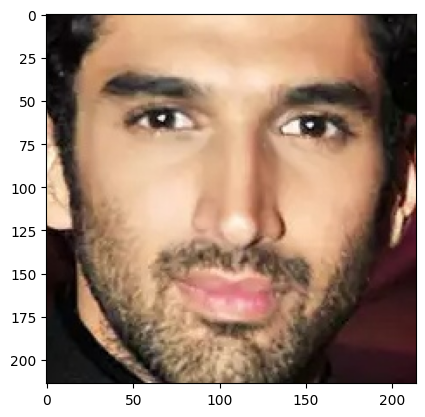

In [10]:
%%time
img = cv2.imread('./test_images/i_always_knew_i_was_a_solo_hero_material_aditya_roy_kapoor.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
check_in_collection(img)

In [11]:
client = MongoClient("mongodb://localhost:27017/")
db = client['unoptimized_image_db']
collection = db['vectors']
def check_in_collection_control(img):
    # print("test")
    img_vector = img_to_encoding(img)

    img_vector = [img_vector.flatten()]

    vectors = collection.find({})
    # print(vectors)
    for vector in vectors:
        if np.linalg.norm(np.array(vector['encoding']) - np.array(img_vector)) < 0.8:
            return vector['name']
    return None

CPU times: user 8.02 s, sys: 273 ms, total: 8.29 s
Wall time: 7.94 s


'aditya roy kapoor'

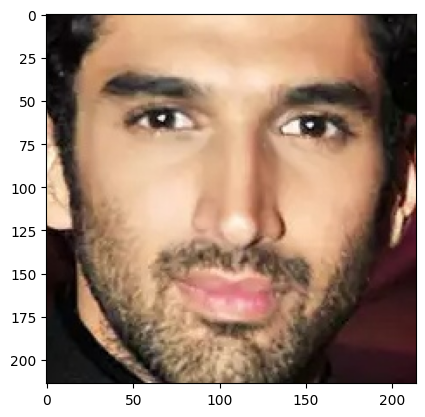

In [12]:
%%time
img = cv2.imread('./test_images/i_always_knew_i_was_a_solo_hero_material_aditya_roy_kapoor.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
check_in_collection_control(img)

In [13]:
client.close()